In [1]:
# !pip install transformers
# !pip install tensorflow_addons

In [1]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification, BertModel, AutoTokenizer, TFBertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
import warnings
warnings.filterwarnings(action='ignore')      

2023-02-25 18:17:10.182191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 18:17:11.113386: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:
2023-02-25 18:17:11.113525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: lib

### Load KlueBert-base Model & Tokenizer 

In [2]:
model_name = "klue/bert-base"
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)
tokenizer = BertTokenizer.from_pretrained(model_name)

2023-02-25 18:17:13.483071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 18:17:13.483509: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 18:17:13.483887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 18:17:13.484259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-25 18:17:13.522858: I tensorflow/compiler/xla/stream_executo

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load Dataset

In [10]:
reviews = pd.read_csv('./reviews.csv')
reviews.shape

(15567, 4)

In [11]:
# "sentiment" classification
# 0 : negative
# 1 : positive

reviews

,Unnamed: 0,reviews,key_sent,sentiment
0,0,15그램에 가격은 비싸지만 쿠폰 사용해서 구매하고 레티놀이 함유되어 있어서 꼭 아침...,0,NaN
1,1,레티놀은 일주일 정도 적응기간을 거친 후 사용하는건데 이 세럼은 다른 기능성도 혼합...,1,1.0
2,2,레티놀과 비타민 C 는 40대인 저에겐 없어서는 안되는 제품인데 혼합된 제품이 나와...,1,1.0
3,3,수부지 홍조 여드름 민감성 피부에도 자극이 하나도 없었어요,1,1.0
4,4,보통 레티놀 비타민 조합들은 따가워서 사용하기 어려웠는데,0,NaN
...,...,...,...,...
15562,15562,한통을 다 비웠는데요,0,NaN
15563,15563,솔직하게 드라마틱한 효과는 없어요,0,NaN
15564,15564,그냥 쫀쩐하게 마무리되는 느낌,1,1.0
15565,15565,화장 전 수분감이랑 유분감이 좀 채워지는 느낌,1,1.0


In [12]:
# 데이터 분리
X = reviews[reviews.key_sent == 1].reviews
y = reviews[reviews.key_sent == 1].sentiment

In [9]:
# 라벨별 비율 확인
y.value_counts(normalize = True)

1.0    0.722389
0.0    0.277611
Name: sentiment, dtype: float64

In [13]:
# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5410,) (602,)
(5410,) (602,)


In [11]:
# train data 라벨별 비율 확인
y_train.value_counts(normalize = True)

1.0    0.722551
0.0    0.277449
Name: sentiment, dtype: float64

In [12]:
# test data 라벨별 비율 확인
y_test.value_counts(normalize = True)

1.0    0.72093
0.0    0.27907
Name: sentiment, dtype: float64

### Conver to BERT input format

In [14]:
MAX_SEQ_LEN = 260

def convert_data(X_data, y_data):
    tokens, masks, segments, targets = [], [], [], []
    
    for X, y in tqdm(zip(X_data, y_data)):

        token = tokenizer.encode(X, truncation = True, padding = 'max_length', max_length = MAX_SEQ_LEN)
        num_zeros = token.count(0)
        mask = [1] * (MAX_SEQ_LEN - num_zeros) + [0] * num_zeros
        segment = [0]*MAX_SEQ_LEN

        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        targets.append(y)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

In [15]:
train_x, train_y = convert_data(X_train, y_train)
test_x, test_y = convert_data(X_test, y_test)

5410it [00:01, 3264.70it/s]
602it [00:00, 3463.54it/s]


## Modeling

In [16]:
# token, mask, segment 입력 정의
token_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids')
mask_inputs = tf.keras.layers.Input((MAX_SEQ_LEN), dtype = tf.int32, name = 'input_masks')
segment_inputs = tf.keras.layers.Input((MAX_SEQ_LEN,), dtype = tf.int32, name = 'input_segment')
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])

In [17]:
bert_output = bert_outputs[0]
bert_output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'tf_bert_for_sequence_classification')>

### # Model 1

In [13]:
dropout = tf.keras.layers.Dropout(0.5)(bert_output)
layer = tf.keras.layers.Dense(128, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(64, activation="relu")(dropout)
layer = tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(layer)
sentiment_model_1= tf.keras.Model([token_inputs, mask_inputs, segment_inputs], layer)

In [16]:
# optimizer - Rectified Adam 
optimizer_name = 'RAdam'
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 5e-5,
                                          total_steps = 10000, 
                                          warmup_proportion = 0.1, 
                                          min_lr = 1e-5, 
                                          epsilon = 1e-8,
                                          clipnorm = 1.0)

In [15]:
sentiment_model_1.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])

In [18]:
# callback function - EarlyStopping

early_stopping = EarlyStopping(
    monitor = "val_accuracy", 
    min_delta = 1e-3,
    patience = 6)

In [34]:
# callback function - ModelCheckpoint

best_model_path1  = './sentiment_best_model_1.h5'

model_checkpoint = ModelCheckpoint(
    filepath = best_model_path1,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True, 
    verbose = 1
)

In [18]:
callbacks1 = [early_stopping, model_checkpoint]

In [19]:
epochs = 70
batch_size = 32

history1 = sentiment_model_1.fit(train_x, train_y, 
                    epochs = epochs, 
                    shuffle = True, 
                    batch_size = batch_size, 
                    validation_split = 0.1,
                    callbacks = callbacks1
                    )

Epoch 1/70
153/153 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.6075
Epoch 1: val_accuracy improved from -inf to 0.72458, saving model to ./sentiment_best_model_1.h5
153/153 [==============================] - 132s 623ms/step - loss: 0.6911 - accuracy: 0.6075 - val_loss: 0.6847 - val_accuracy: 0.7246
Epoch 2/70
153/153 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.6880
Epoch 2: val_accuracy improved from 0.72458 to 0.90018, saving model to ./sentiment_best_model_1.h5
153/153 [==============================] - 143s 936ms/step - loss: 0.6647 - accuracy: 0.6880 - val_loss: 0.6336 - val_accuracy: 0.9002
Epoch 3/70
153/153 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.7689
Epoch 3: val_accuracy improved from 0.90018 to 0.91682, saving model to ./sentiment_best_model_1.h5
153/153 [==============================] - 123s 807ms/step - loss: 0.5993 - accuracy: 0.7689 - val_loss: 0.5538 - val_accuracy: 0.9168
Epoch 4/70

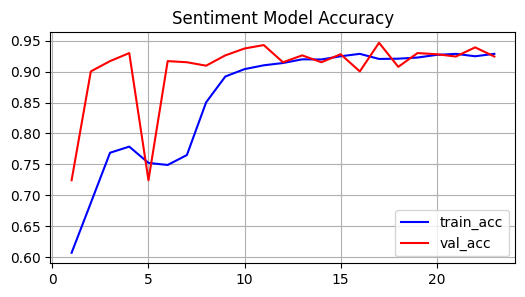

In [33]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

epochs = range(1, len(acc)+1)
plt.figure(figsize=(6, 3))
plt.title('Sentiment Model Accuracy')
plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.savefig('./Sentiment_Model_Accuracy_1.png')
plt.show()

In [35]:
sentiment_model_1 = tf.keras.models.load_model(best_model_path1,
                                               custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [36]:
test_eval_1 = sentiment_model_1.evaluate(test_x, test_y)

19/19 [==============================] - 7s 186ms/step - loss: 0.3141 - accuracy: 0.9136


### # Model 2

In [23]:
dropout = tf.keras.layers.Dropout(0.5)(bert_output)
layer = tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(layer)
sentiment_model_2 = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], layer)

In [24]:
sentiment_model_2.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])

In [18]:
best_model_path2 = './sentiment_best_model_2.h5'

model_checkpoint2 = ModelCheckpoint(
    filepath = best_model_path2,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True, 
    verbose = 1)

In [26]:
callbacks2 = [early_stopping, model_checkpoint2]

In [27]:
epochs = 70
BATCH_SZIE = 32

history2 = sentiment_model_2.fit(train_x, train_y, 
                    epochs = epochs, 
                    shuffle = True, 
                    batch_size = batch_size, 
                    validation_split = 0.1,
                    callbacks = callbacks2)

Epoch 1/70
153/153 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.9240
Epoch 1: val_accuracy improved from -inf to 0.92606, saving model to ./sentiment_best_model_2.h5
153/153 [==============================] - 129s 623ms/step - loss: 0.6731 - accuracy: 0.9240 - val_loss: 0.6606 - val_accuracy: 0.9261
Epoch 2/70
153/153 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.9185
Epoch 2: val_accuracy improved from 0.92606 to 0.93530, saving model to ./sentiment_best_model_2.h5
153/153 [==============================] - 118s 772ms/step - loss: 0.6557 - accuracy: 0.9185 - val_loss: 0.6464 - val_accuracy: 0.9353
Epoch 3/70
153/153 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.9146
Epoch 3: val_accuracy did not improve from 0.93530
153/153 [==============================] - 89s 583ms/step - loss: 0.6447 - accuracy: 0.9146 - val_loss: 0.6358 - val_accuracy: 0.9335
Epoch 4/70
153/153 [==============================] - ETA: 0

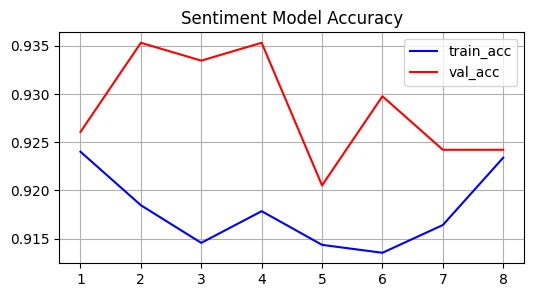

In [32]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(acc)+1)
plt.figure(figsize=(6, 3))
plt.title('Sentiment Model Accuracy')
plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.savefig('./Sentiment_Model_Accuracy_2.png')
plt.show()

In [19]:
sentiment_model_2 = tf.keras.models.load_model(best_model_path2,
                                               custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [20]:
test_eval_2 = sentiment_model_2.evaluate(test_x, test_y)

19/19 [==============================] - 7s 186ms/step - loss: 0.6471 - accuracy: 0.9219


### # Model 3

In [26]:
dropout = tf.keras.layers.Dropout(0.5)(bert_output)
layer = tf.keras.layers.Dense(64, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(32, activation="relu")(dropout)
layer = tf.keras.layers.Dense(2, activation='softmax', 
                              kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(dropout)
sentiment_model_3 = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], layer)

In [27]:
sentiment_model_3.compile(optimizer = optimizer, 
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                        metrics = ['accuracy'])

In [28]:
best_model_path3 = './sentiment_best_model_3.h5'

model_checkpoint3 = ModelCheckpoint(
    filepath = best_model_path3,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True, 
    verbose = 1)

In [29]:
callbacks3 = [early_stopping, model_checkpoint3]

epchs = 70
batch_size = 32

history3 = sentiment_model_3.fit(train_x, train_y, 
                    epochs = epchs, 
                    shuffle = True, 
                    batch_size = batch_size, 
                    validation_split = 0.1,
                    callbacks = callbacks3)

Epoch 1/70
153/153 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.8899
Epoch 1: val_accuracy improved from -inf to 0.91867, saving model to ./sentiment_best_model_3.h5
153/153 [==============================] - 154s 797ms/step - loss: 0.3103 - accuracy: 0.8899 - val_loss: 0.2196 - val_accuracy: 0.9187
Epoch 2/70
153/153 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9139
Epoch 2: val_accuracy improved from 0.91867 to 0.92052, saving model to ./sentiment_best_model_3.h5
153/153 [==============================] - 112s 736ms/step - loss: 0.2488 - accuracy: 0.9139 - val_loss: 0.2491 - val_accuracy: 0.9205
Epoch 3/70
153/153 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9162
Epoch 3: val_accuracy did not improve from 0.92052
153/153 [==============================] - 89s 583ms/step - loss: 0.2347 - accuracy: 0.9162 - val_loss: 0.2351 - val_accuracy: 0.9205
Epoch 4/70
153/153 [==============================] - ETA: 0

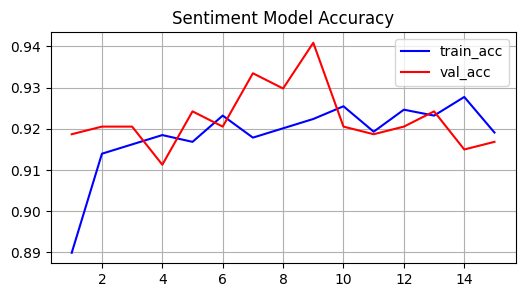

In [30]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(acc)+1)
plt.figure(figsize=(6, 3))
plt.title('Sentiment Model Accuracy')
plt.plot(epochs, acc, 'b', label='train_acc')
plt.plot(epochs, val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.savefig('./Sentiment_Model_Accuracy_3.png')
plt.show()

In [31]:
sentiment_model_3 = tf.keras.models.load_model(best_model_path3,
                                               custom_objects={'TFBertForSequenceClassification': TFBertForSequenceClassification})

In [32]:
test_eval_3 = sentiment_model_3.evaluate(test_x, test_y)

19/19 [==============================] - 7s 187ms/step - loss: 0.3247 - accuracy: 0.9120


## Evaluation

In [40]:
# 3가지 모델 Accuracy 비교
test_evals = [test_eval_1[1], test_eval_2[1], test_eval_3[1]]
test_evals

[0.9136212468147278, 0.9219269156455994, 0.9119601249694824]

In [21]:
# Accuracy가 가장 높은 2번 모델로 평가 진행
predicted_value = sentiment_model_2.predict(test_x)
predicted_label = np.argmax(predicted_value, axis = 1)

19/19 [==============================] - 7s 184ms/step


#### Classification Report

In [32]:
CL_REPORT_FILE = "./cl_report_sentiment.csv"

cl_report = classification_report(test_y, predicted_label, output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(3)
cl_report_df.to_csv(CL_REPORT_FILE)
cl_report_df

,precision,recall,f1-score,support
0.0,0.881,0.833,0.856,168.000
1.0,0.937,0.956,0.946,434.000
accuracy,0.922,0.922,0.922,0.922
macro avg,0.909,0.895,0.901,602.000
weighted avg,0.921,0.922,0.921,602.000


#### Confusion Matrix

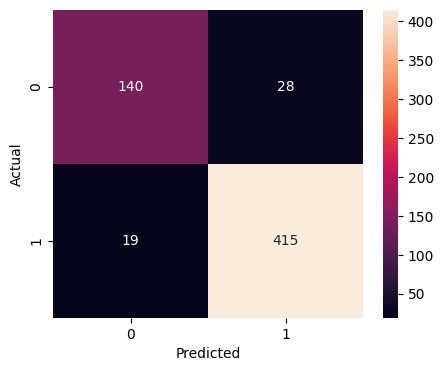

In [23]:
figure_file = "./cf_matrix_sentiment.png"

cf_matrix = confusion_matrix(test_y, predicted_label)
fig, ax = plt.subplots(figsize = (5,4))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(figure_file)
plt.show()

#### Total Metrics

In [24]:
accuracy_score = round(accuracy_score(y_test, predicted_label), 3) 
precision_score = round(precision_score(y_test, predicted_label, average="weighted"), 3) 
recall_score = round(recall_score(y_test, predicted_label, average="weighted"), 3) 
f1_score = round(f1_score(y_test, predicted_label, average="weighted"), 3) 
roc_auc_score = round(roc_auc_score(y_test, predicted_label, average="weighted", multi_class="ovr"), 3) 
cohen_kappa_score = round(cohen_kappa_score(y_test, predicted_label), 3)
matthews_corrcoef = round(matthews_corrcoef(y_test, predicted_label), 3) 
log_loss_= round(log_loss(y_test, predicted_label), 3) # Log Loss

In [27]:
metric_file = './metric_sentiment.csv'

metric_total = pd.DataFrame({
    'PLM': model_name,
    'Optimizer': optimizer_name,
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1_score': f1_score,
    'ROC_AUC_score': roc_auc_score,
    'Cohen_kappa_coef': cohen_kappa_score,
    'Matthews_corrcoef': matthews_corrcoef,
    'Log_loss': log_loss_},
    index = ['-'])  

In [28]:
metric_total.to_csv(metric_file)

In [29]:
metric_total

,PLM,Optimizer,Accuracy,Precision,Recall,F1_score,ROC_AUC_score,Cohen_kappa_coef,Matthews_corrcoef,Log_loss
-,klue/bert_-base,RAdam,0.922,0.921,0.922,0.921,0.895,0.803,0.803,2.814


### Final Training

In [30]:
sentiment_model_2.fit(test_x, test_y, 
                      epochs=30, 
                      shuffle = True, batch_size = 32)

Epoch 1/30
19/19 [==============================] - 33s 559ms/step - loss: 0.6534 - accuracy: 0.8571
Epoch 2/30
19/19 [==============================] - 11s 559ms/step - loss: 0.6537 - accuracy: 0.8654
Epoch 3/30
19/19 [==============================] - 11s 559ms/step - loss: 0.6544 - accuracy: 0.8571
Epoch 4/30
19/19 [==============================] - 11s 559ms/step - loss: 0.6541 - accuracy: 0.8638
Epoch 5/30
19/19 [==============================] - 11s 560ms/step - loss: 0.6518 - accuracy: 0.8804
Epoch 6/30
19/19 [==============================] - 11s 560ms/step - loss: 0.6553 - accuracy: 0.8355
Epoch 7/30
19/19 [==============================] - 11s 559ms/step - loss: 0.6542 - accuracy: 0.8538
Epoch 8/30
19/19 [==============================] - 11s 560ms/step - loss: 0.6530 - accuracy: 0.8738
Epoch 9/30
19/19 [==============================] - 11s 560ms/step - loss: 0.6534 - accuracy: 0.8638
Epoch 10/30
19/19 [==============================] - 11s 561ms/step - loss: 0.6522 - accura

In [31]:
model_path = "./final_sentiment_model.h5"
sentiment_model_2.save(model_path)